# Classificação de Documentos com YOLO11

## Objetivo do Projeto

Este notebook demonstra como utilizar o modelo YOLO11 (You Only Look Once) para **classificação automática de documentos**. Diferente da detecção de objetos, onde o modelo identifica e localiza múltiplos objetos em uma imagem, na classificação o objetivo é atribuir uma única categoria/classe a cada imagem de documento.

## Dataset: RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing)

Estamos utilizando uma versão do dataset RVL-CDIP, que contém **16 categorias de documentos**:

1. **advertisement** - Anúncios e propagandas
2. **budget** - Documentos orçamentários
3. **email** - Emails impressos
4. **file_folder** - Capas de pastas
5. **form** - Formulários
6. **handwritten** - Documentos manuscritos
7. **invoice** - Faturas e notas fiscais
8. **letter** - Cartas
9. **memo** - Memorandos
10. **news_article** - Artigos de jornal
11. **presentation** - Slides de apresentação
12. **questionnaire** - Questionários
13. **resume** - Currículos
14. **scientific_publication** - Publicações científicas
15. **scientific_report** - Relatórios científicos
16. **specification** - Especificações técnicas

Cada categoria contém aproximadamente **2.500 imagens**, totalizando cerca de **40.000 documentos** no conjunto de teste.

## Por que usar YOLO para Classificação?

Embora o YOLO seja mais conhecido para detecção de objetos, a arquitetura YOLO11-cls (classification) oferece várias vantagens:

- **Velocidade**: Inferência extremamente rápida, ideal para processamento em lote
- **Eficiência**: Modelo leve que pode rodar em CPUs
- **Precisão**: Resultados competitivos com arquiteturas mais complexas
- **Facilidade de uso**: API simples e intuitiva do Ultralytics

## Estrutura do Notebook

1. **Setup** - Instalação de dependências
2. **Exploração dos Dados** - Análise do dataset
3. **Preparação do Dataset** - Organização para YOLO11
4. **Treinamento** - Fine-tuning do modelo
5. **Validação** - Avaliação de performance
6. **Inferência** - Classificação de novos documentos
7. **Exportação** - Conversão para diferentes formatos

## 1. Setup

### Instalação do Ultralytics

O pacote `ultralytics` contém toda a implementação do YOLO11, incluindo:
- Modelos pré-treinados
- Funções de treinamento e validação
- Utilitários para processamento de imagens
- Exportação para diversos formatos

A função `ultralytics.checks()` verifica:
- Versão do Python
- Versão do PyTorch
- Hardware disponível (CPU/GPU)
- Memória e armazenamento

In [1]:
# Instalar ultralytics e verificar ambiente
!uv pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.5 torch-2.4.0 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 421.4/460.4 GB disk)


## 2. Exploração do Dataset

### Estrutura de Diretórios

O dataset está organizado seguindo a estrutura esperada pelo YOLO11 para classificação:

```
data/test/
├── advertisement/
│   ├── imagem1.tif
│   ├── imagem2.tif
│   └── ...
├── budget/
│   └── ...
└── ...
```

Cada subdiretório representa uma **classe** e contém as imagens daquela categoria.

### Análise Estatística

Vamos verificar:
- Número total de categorias
- Distribuição de imagens por categoria
- Formato e dimensões das imagens

Total de categorias: 16
Total de imagens: 919

Distribuição por categoria:
--------------------------------------------------
advertisement                 :    58 imagens
budget                        :    58 imagens
email                         :    58 imagens
file_folder                   :    58 imagens
form                          :    58 imagens
handwritten                   :    58 imagens
invoice                       :    57 imagens
letter                        :    57 imagens
memo                          :    57 imagens
news_article                  :    56 imagens
presentation                  :    57 imagens
questionnaire                 :    56 imagens
resume                        :    58 imagens
scientific_publication        :    59 imagens
scientific_report             :    57 imagens
specification                 :    57 imagens


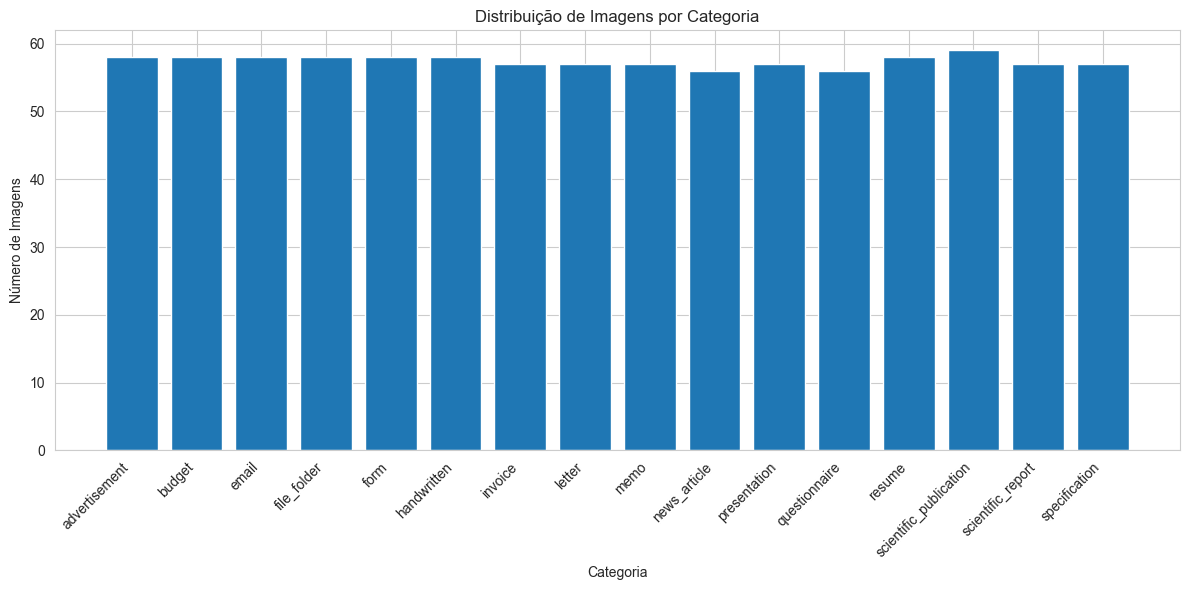


Dataset balanceado: False


In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

# Caminho base do dataset
data_path = Path('data/test')

# Contar imagens por categoria
categories = {}
for category_dir in sorted(data_path.iterdir()):
    if category_dir.is_dir():
        num_images = len(list(category_dir.glob('*.tif')))
        categories[category_dir.name] = num_images

# Exibir estatísticas
print(f"Total de categorias: {len(categories)}")
print(f"Total de imagens: {sum(categories.values())}")
print(f"\nDistribuição por categoria:")
print("-" * 50)

for cat, count in categories.items():
    print(f"{cat:30s}: {count:5d} imagens")

# Visualizar distribuição
plt.figure(figsize=(12, 6))
plt.bar(range(len(categories)), list(categories.values()))
plt.xticks(range(len(categories)), list(categories.keys()), rotation=45, ha='right')
plt.xlabel('Categoria')
plt.ylabel('Número de Imagens')
plt.title('Distribuição de Imagens por Categoria')
plt.tight_layout()
plt.show()

print(f"\nDataset balanceado: {len(set(categories.values())) <= 3}")

### Visualização de Amostras

Vamos visualizar alguns exemplos de cada categoria para entender melhor os tipos de documentos:

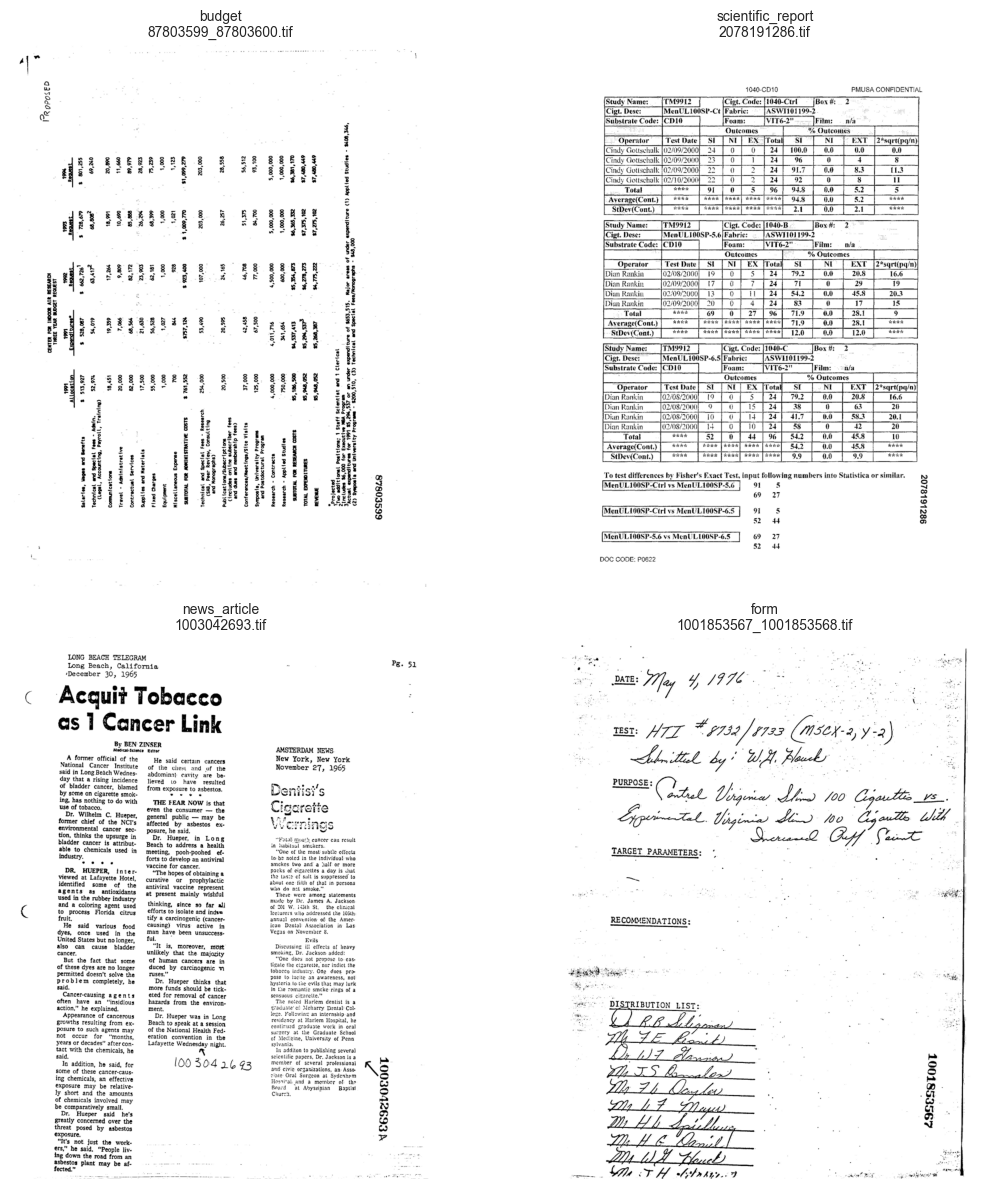

In [3]:
from PIL import Image
import random

# Selecionar 4 categorias aleatórias para visualização
sample_categories = random.sample(list(categories.keys()), 4)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, category in enumerate(sample_categories):
    # Pegar uma imagem aleatória da categoria
    category_path = data_path / category
    images = list(category_path.glob('*.tif'))
    sample_image = random.choice(images)
    
    # Carregar e exibir
    img = Image.open(sample_image)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'{category}\n{sample_image.name}', fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 3. Preparação do Dataset para YOLO11

### Estrutura de Diretórios para Classificação

**IMPORTANTE**: Diferente de detecção de objetos, o YOLO11-cls **NÃO usa arquivos YAML**. 

Para classificação, o YOLO11 espera apenas a seguinte estrutura de diretórios:

```
data/
├── train/
│   ├── classe1/
│   │   ├── img1.tif
│   │   ├── img2.tif
│   │   └── ...
│   ├── classe2/
│   │   └── ...
│   └── ...
├── val/
│   ├── classe1/
│   │   └── ...
│   └── ...
└── test/
    ├── classe1/
    │   └── ...
    └── ...
```

### Como o YOLO11 Identifica as Classes

- O **nome do subdiretório** é o nome da classe
- As classes são ordenadas **alfabeticamente**
- Não precisa de mapeamento manual ou arquivo de configuração

### Divisão Train/Val/Test

Para treinamento adequado, precisamos dividir o dataset:
- **70% Treinamento**: Para aprender padrões
- **15% Validação**: Para ajustar hiperparâmetros durante o treino
- **15% Teste**: Para avaliação final não enviesada

Atualmente temos apenas o conjunto `test/`. Vamos criar os splits:

### Criação de Splits de Treino e Validação (Opcional)

Para um treinamento adequado, vamos criar splits de treino e validação a partir do conjunto de teste:

In [4]:
import shutil
from sklearn.model_selection import train_test_split

def create_train_val_split(test_path, train_size=0.7, val_size=0.15, seed=42):
    """
    Divide o conjunto de teste em treino, validação e teste.
    
    Parâmetros:
    - test_path: Caminho para o diretório de teste
    - train_size: Proporção para treino (0.7 = 70%)
    - val_size: Proporção para validação (0.15 = 15%)
    - seed: Semente para reprodutibilidade
    
    O restante (0.15 = 15%) ficará como teste.
    """
    test_path = Path(test_path)
    base_path = test_path.parent
    train_path = base_path / 'train'
    val_path = base_path / 'val'
    
    # Criar diretórios se não existirem
    train_path.mkdir(exist_ok=True)
    val_path.mkdir(exist_ok=True)
    
    stats = {'train': 0, 'val': 0, 'test': 0}
    
    # Processar cada categoria
    for category_dir in test_path.iterdir():
        if not category_dir.is_dir():
            continue
            
        category_name = category_dir.name
        images = list(category_dir.glob('*.tif'))
        
        # Dividir em treino/temporário (val+test)
        train_imgs, temp_imgs = train_test_split(
            images, 
            train_size=train_size, 
            random_state=seed
        )
        
        # Dividir temporário em val/test
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            train_size=val_size/(1-train_size),  # Ajustar proporção
            random_state=seed
        )
        
        # Criar diretórios de categoria
        (train_path / category_name).mkdir(exist_ok=True)
        (val_path / category_name).mkdir(exist_ok=True)
        
        # Copiar imagens de treino
        for img in train_imgs:
            shutil.copy2(img, train_path / category_name / img.name)
        
        # Copiar imagens de validação
        for img in val_imgs:
            shutil.copy2(img, val_path / category_name / img.name)
        
        # Remover imagens de treino e validação do test (manter apenas test)
        for img in train_imgs + val_imgs:
            img.unlink()
        
        stats['train'] += len(train_imgs)
        stats['val'] += len(val_imgs)
        stats['test'] += len(test_imgs)
        
        print(f"{category_name:30s}: {len(train_imgs):4d} train, {len(val_imgs):4d} val, {len(test_imgs):4d} test")
    
    print(f"\nTotal: {stats['train']} train, {stats['val']} val, {stats['test']} test")
    return stats

# ATENÇÃO: Esta célula modifica os arquivos! Execute apenas uma vez.
# Descomente a linha abaixo para criar os splits train/val/test
stats = create_train_val_split('data/test')

print("ATENÇÃO: Para criar os splits, descomente a última linha e execute.")
print("Isso moverá ~70% das imagens para train/ e ~15% para val/")
print("Mantendo ~15% em test/")

form                          :   40 train,    8 val,   10 test
news_article                  :   39 train,    8 val,    9 test
handwritten                   :   40 train,    8 val,   10 test
resume                        :   40 train,    8 val,   10 test
letter                        :   39 train,    8 val,   10 test
specification                 :   39 train,    8 val,   10 test
questionnaire                 :   39 train,    8 val,    9 test
memo                          :   39 train,    8 val,   10 test
scientific_report             :   39 train,    8 val,   10 test
scientific_publication        :   41 train,    8 val,   10 test
file_folder                   :   40 train,    8 val,   10 test
advertisement                 :   40 train,    8 val,   10 test
presentation                  :   39 train,    8 val,   10 test
email                         :   40 train,    8 val,   10 test
invoice                       :   39 train,    8 val,   10 test
budget                        :   40 tra

## 4. Treinamento do Modelo

### Escolha do Modelo Base

O YOLO11 oferece diferentes tamanhos de modelos de classificação:

| Modelo | Parâmetros | Tamanho | Velocidade | Precisão |
|--------|-----------|---------|------------|----------|
| yolo11n-cls.pt | 1.4M | ~3 MB | Muito Rápido | Boa |
| yolo11s-cls.pt | 5.5M | ~11 MB | Rápido | Muito Boa |
| yolo11m-cls.pt | 13M | ~26 MB | Médio | Excelente |
| yolo11l-cls.pt | 25M | ~50 MB | Lento | Excelente |
| yolo11x-cls.pt | 56M | ~112 MB | Muito Lento | Melhor |

Para este tutorial, usaremos **yolo11n-cls.pt** (nano) que é:
- Rápido para treinar
- Pequeno em tamanho
- Adequado para CPUs
- Bom ponto de partida para experimentação

### Hiperparâmetros de Treinamento

Principais parâmetros:
- **epochs**: Número de épocas (passadas completas pelo dataset)
- **imgsz**: Tamanho das imagens de entrada (224, 320, 640)
- **batch**: Tamanho do batch (número de imagens processadas por vez)
- **lr0**: Taxa de aprendizado inicial
- **device**: 'cpu' ou 'cuda' (GPU)

### Transfer Learning

O modelo pré-treinado em ImageNet já conhece:
- Bordas e texturas
- Formas geométricas
- Padrões visuais gerais

Vamos fazer **fine-tuning** para adaptar ao domínio de documentos.

### 3.1. Gerenciamento de Checkpoints

Antes de iniciar o treinamento, é importante entender o sistema de checkpoints do YOLO11:

#### O que são Checkpoints?

Checkpoints são **snapshots do modelo** salvos durante o treinamento, permitindo:
- **Retomar treinamento interrompido**: Se o treinamento parar (falta de energia, erro, etc.)
- **Experimentação incremental**: Treinar por algumas épocas, avaliar, e continuar se necessário
- **Proteção contra perda de progresso**: Especialmente importante em treinos longos

#### Tipos de Checkpoints Salvos

O YOLO11 salva automaticamente dois checkpoints:

1. **`last.pt`**: Modelo da última época completada
   - Sempre atualizado
   - Usado para retomar o treinamento
   - Pode não ser o melhor modelo

2. **`best.pt`**: Melhor modelo baseado na métrica de validação
   - Salvo quando há melhoria na performance
   - Usado para inferência e avaliação final
   - Pode ser de uma época anterior

#### Estrutura de Diretórios

```
runs/classify/document_classifier/
├── weights/
│   ├── last.pt          # Último checkpoint
│   └── best.pt          # Melhor checkpoint
├── results.csv          # Histórico de métricas
├── confusion_matrix.png # Matriz de confusão
└── ...
```

#### Parâmetros Importantes

- **`save=True`**: Habilita salvamento de checkpoints (padrão)
- **`save_period=-1`**: Frequência de salvamento (-1 = apenas last e best)
- **`resume=True`**: Retoma do último checkpoint automaticamente
- **`resume='caminho/para/last.pt'`**: Retoma de checkpoint específico
- **`exist_ok=True`**: Permite sobrescrever experimentos existentes
- **`patience=10`**: Early stopping - para se não houver melhora por N épocas

#### Cenários de Uso

**Cenário 1: Primeiro Treinamento**
```python
model.train(data='data', epochs=50, save=True)
```

**Cenário 2: Treinamento Interrompido - Retomar Automaticamente**
```python
model.train(data='data', resume=True)  # Procura último checkpoint automaticamente
```

**Cenário 3: Retomar de Checkpoint Específico**
```python
model.train(data='data', resume='runs/classify/document_classifier/weights/last.pt')
```

**Cenário 4: Continuar Treinando o Melhor Modelo**
```python
model = YOLO('runs/classify/document_classifier/weights/best.pt')
model.train(data='data', epochs=20)  # Treina mais 20 épocas
```

In [ ]:
from ultralytics import YOLO

# Carregar modelo pré-treinado
model = YOLO('yolo11n-cls.pt')  # Modelo de classificação nano

# Configurar TensorBoard para acompanhar treinamento
!yolo settings tensorboard=True

# Treinar o modelo
# IMPORTANTE: Para classificação, passamos apenas o caminho do diretório 'data'
# O YOLO11 automaticamente procura por subdiretórios train/, val/ e test/
results = model.train(
    data='data',                                  # Apenas o caminho do diretório base
    epochs=50,                                    # 50 épocas
    imgsz=224,                                    # Imagens de 224x224
    batch=32,                                     # 32 imagens por batch
    patience=10,                                  # Early stopping após 10 épocas sem melhora
    save=True,                                    # Salvar checkpoints (last.pt e best.pt)
    save_period=-1,                               # -1 = salvar apenas last e best (economiza espaço)
    device='cpu',                                 # Usar CPU (mude para 'cuda' se tiver GPU)
    workers=4,                                    # 4 workers para carregar dados
    project='runs/classify',                      # Diretório de saída
    name='document_classifier',                   # Nome do experimento
    exist_ok=True                                 # Sobrescrever se existir
)

print("\nTreinamento concluído!")
print(f"Modelo salvo em: {results.save_dir}")
print(f"Melhor modelo: {results.save_dir}/weights/best.pt")
print(f"Último checkpoint: {results.save_dir}/weights/last.pt")

✅ Updated 'tensorboard=True'
JSONDict("/Users/jwcunha/Library/Application Support/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/Users/jwcunha/Documents/development/sharping/pocs/mineru-textile/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "e5412978b795102e350024fe032934edc5bb3ed9305853ecbeff7af105ff6dd4",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings
Ultralytics 8.3.221 🚀 Python-3.12.5 torch-2.4.0 CPU (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, 

### 4.1. Retomar Treinamento Interrompido

Se o treinamento for interrompido por qualquer motivo (erro, falta de energia, interrupção manual), você pode retomá-lo facilmente:

#### Opção 1: Retomar Automaticamente

O YOLO11 procura automaticamente o último checkpoint no diretório do projeto:

In [ ]:
# Retomar treinamento automaticamente
# YOLO11 procura o último checkpoint em runs/classify/document_classifier/weights/last.pt

from ultralytics import YOLO

# Carregar modelo inicial (será ignorado se houver checkpoint)
model = YOLO('yolo11n-cls.pt')

# Retomar treinamento
# Se houver checkpoint, continua de onde parou
# Se não houver, começa do zero
results = model.train(
    data='data',
    resume=True,  # Ativa retomada automática
    # Todos os outros parâmetros são carregados do checkpoint
)

print("\nTreinamento retomado/concluído!")
print(f"Modelo salvo em: {results.save_dir}")

#### Opção 2: Retomar de Checkpoint Específico

Se você tem múltiplos experimentos ou quer retomar de um checkpoint específico:

In [ ]:
# Retomar de checkpoint específico
from ultralytics import YOLO

# Especificar caminho exato do checkpoint
checkpoint_path = 'runs/classify/document_classifier/weights/last.pt'

# Verificar se checkpoint existe
if Path(checkpoint_path).exists():
    print(f"Checkpoint encontrado: {checkpoint_path}")
    
    # Carregar modelo inicial
    model = YOLO('yolo11n-cls.pt')
    
    # Retomar do checkpoint específico
    results = model.train(
        data='data',
        resume=checkpoint_path,  # Caminho do checkpoint
    )
    
    print(f"\nTreinamento retomado de: {checkpoint_path}")
    print(f"Modelo salvo em: {results.save_dir}")
else:
    print(f"Checkpoint não encontrado: {checkpoint_path}")
    print("Execute primeiro a célula de treinamento inicial.")

### 4.2. Monitoramento de Checkpoints e Progresso

Durante e após o treinamento, você pode monitorar o progresso através de várias fontes:

#### Histórico de Métricas (results.csv)

O arquivo `results.csv` contém todas as métricas de cada época:

In [ ]:
# Visualizar histórico de treinamento
import pandas as pd
import matplotlib.pyplot as plt

results_csv = 'runs/classify/document_classifier/results.csv'

if Path(results_csv).exists():
    # Carregar histórico
    df = pd.read_csv(results_csv)
    
    # Remover espaços dos nomes das colunas
    df.columns = df.columns.str.strip()
    
    print("Histórico de Treinamento:")
    print("=" * 80)
    print(df.to_string(index=False))
    
    # Visualizar curvas de treinamento
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss de treinamento e validação
    if 'train/loss' in df.columns and 'val/loss' in df.columns:
        axes[0, 0].plot(df['epoch'], df['train/loss'], label='Train Loss', marker='o')
        axes[0, 0].plot(df['epoch'], df['val/loss'], label='Val Loss', marker='s')
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Curva de Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # Acurácia Top-1
    if 'metrics/accuracy_top1' in df.columns:
        axes[0, 1].plot(df['epoch'], df['metrics/accuracy_top1'] * 100, 
                       label='Top-1 Accuracy', marker='o', color='green')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].set_ylabel('Acurácia (%)')
        axes[0, 1].set_title('Top-1 Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Acurácia Top-5
    if 'metrics/accuracy_top5' in df.columns:
        axes[1, 0].plot(df['epoch'], df['metrics/accuracy_top5'] * 100,
                       label='Top-5 Accuracy', marker='o', color='blue')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Acurácia (%)')
        axes[1, 0].set_title('Top-5 Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    if 'lr/pg0' in df.columns:
        axes[1, 1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', 
                       marker='o', color='orange')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas resumidas
    print("\n" + "=" * 80)
    print("Estatísticas Resumidas:")
    print("=" * 80)
    if 'metrics/accuracy_top1' in df.columns:
        best_epoch = df.loc[df['metrics/accuracy_top1'].idxmax()]
        print(f"Melhor época: {int(best_epoch['epoch'])}")
        print(f"Melhor Top-1 Accuracy: {best_epoch['metrics/accuracy_top1']:.4f} "
              f"({best_epoch['metrics/accuracy_top1']*100:.2f}%)")
        if 'metrics/accuracy_top5' in df.columns:
            print(f"Top-5 Accuracy (melhor época): {best_epoch['metrics/accuracy_top5']:.4f} "
                  f"({best_epoch['metrics/accuracy_top5']*100:.2f}%)")
        
        # Última época
        last_epoch = df.iloc[-1]
        print(f"\nÚltima época: {int(last_epoch['epoch'])}")
        print(f"Top-1 Accuracy (última): {last_epoch['metrics/accuracy_top1']:.4f} "
              f"({last_epoch['metrics/accuracy_top1']*100:.2f}%)")
        
else:
    print(f"Arquivo de resultados não encontrado: {results_csv}")
    print("Execute o treinamento primeiro.")

#### Comparação entre Best e Last Checkpoints

É importante entender a diferença entre os dois checkpoints salvos:

In [ ]:
# Comparar checkpoints best.pt e last.pt
from ultralytics import YOLO
import os

checkpoint_dir = 'runs/classify/document_classifier/weights'
best_path = f'{checkpoint_dir}/best.pt'
last_path = f'{checkpoint_dir}/last.pt'

if Path(best_path).exists() and Path(last_path).exists():
    print("Comparação de Checkpoints:")
    print("=" * 80)
    
    # Informações de arquivo
    best_size = os.path.getsize(best_path) / (1024 * 1024)  # MB
    last_size = os.path.getsize(last_path) / (1024 * 1024)  # MB
    
    best_time = os.path.getmtime(best_path)
    last_time = os.path.getmtime(last_path)
    
    from datetime import datetime
    best_date = datetime.fromtimestamp(best_time).strftime('%Y-%m-%d %H:%M:%S')
    last_date = datetime.fromtimestamp(last_time).strftime('%Y-%m-%d %H:%M:%S')
    
    print(f"\nBest Checkpoint (best.pt):")
    print(f"  Tamanho: {best_size:.2f} MB")
    print(f"  Modificado: {best_date}")
    print(f"  Uso: Inferência e avaliação final")
    
    print(f"\nLast Checkpoint (last.pt):")
    print(f"  Tamanho: {last_size:.2f} MB")
    print(f"  Modificado: {last_date}")
    print(f"  Uso: Retomar treinamento")
    
    # Validar ambos os modelos no conjunto de validação
    print("\n" + "=" * 80)
    print("Validação Comparativa (val set):")
    print("=" * 80)
    
    # Validar best.pt
    print("\n1. Validando best.pt...")
    best_model = YOLO(best_path)
    best_results = best_model.val(data='data', split='val', verbose=False)
    
    # Validar last.pt
    print("2. Validando last.pt...")
    last_model = YOLO(last_path)
    last_results = last_model.val(data='data', split='val', verbose=False)
    
    # Comparar resultados
    print("\n" + "=" * 80)
    print("Resultados:")
    print("=" * 80)
    print(f"\n{'Métrica':<25} {'best.pt':<15} {'last.pt':<15} {'Diferença'}")
    print("-" * 80)
    print(f"{'Top-1 Accuracy':<25} {best_results.top1:.4f} ({best_results.top1*100:5.2f}%)  "
          f"{last_results.top1:.4f} ({last_results.top1*100:5.2f}%)  "
          f"{(last_results.top1 - best_results.top1)*100:+.2f}%")
    print(f"{'Top-5 Accuracy':<25} {best_results.top5:.4f} ({best_results.top5*100:5.2f}%)  "
          f"{last_results.top5:.4f} ({last_results.top5*100:5.2f}%)  "
          f"{(last_results.top5 - best_results.top5)*100:+.2f}%")
    
    print("\n" + "=" * 80)
    print("Recomendação:")
    print("=" * 80)
    if best_results.top1 > last_results.top1:
        print("Use best.pt para inferência (melhor performance)")
        print("Use last.pt apenas para retomar o treinamento")
    else:
        print("Os checkpoints têm performance similar")
        print("Provavelmente a melhor época foi a última")
    
else:
    if not Path(best_path).exists():
        print(f"Checkpoint não encontrado: {best_path}")
    if not Path(last_path).exists():
        print(f"Checkpoint não encontrado: {last_path}")
    print("Execute o treinamento primeiro.")

### Visualização do Treinamento com TensorBoard

TensorBoard permite acompanhar:
- Loss de treinamento e validação
- Acurácia top-1 e top-5
- Taxa de aprendizado
- Exemplos de predições

In [ ]:
# Carregar TensorBoard
%load_ext tensorboard
%tensorboard --logdir runs/classify/document_classifier

## 5. Validação do Modelo

### Métricas de Classificação

Para avaliar o modelo, usamos:

1. **Acurácia (Accuracy)**: Percentual de predições corretas
   - `accuracy = (predições_corretas) / (total_predições)`

2. **Top-5 Accuracy**: Percentual onde a classe correta está entre as 5 mais prováveis
   - Útil para entender se o modelo está "perto" da resposta certa

3. **Matriz de Confusão**: Mostra quais classes são confundidas entre si
   - Linhas: Classes verdadeiras
   - Colunas: Classes preditas
   - Diagonal: Predições corretas

4. **Precision, Recall, F1-Score** (por classe):
   - **Precision**: Das predições para esta classe, quantas estavam corretas?
   - **Recall**: Desta classe, quantas foram encontradas?
   - **F1**: Média harmônica entre precision e recall

In [ ]:
# Carregar melhor modelo treinado
best_model = YOLO('runs/classify/document_classifier/weights/best.pt')

# Validar no conjunto de validação
# Para classificação, passamos apenas o caminho do diretório base
val_results = best_model.val(
    data='data',  # Diretório base (YOLO11 procura por data/val/)
    split='val'
)

# Exibir métricas
print("\nMétricas de Validação:")
print("-" * 50)
print(f"Top-1 Accuracy: {val_results.top1:.4f}")
print(f"Top-5 Accuracy: {val_results.top5:.4f}")

### Avaliação no Conjunto de Teste

O conjunto de teste deve ser usado **apenas uma vez**, após todo o desenvolvimento e ajuste do modelo, para obter a métrica final não enviesada.

In [ ]:
# Testar no conjunto de teste
test_results = best_model.val(
    data='data',  # Diretório base (YOLO11 procura por data/test/)
    split='test'
)

print("\nMétricas de Teste (Avaliação Final):")
print("-" * 50)
print(f"Top-1 Accuracy: {test_results.top1:.4f}")
print(f"Top-5 Accuracy: {test_results.top5:.4f}")

### Análise da Matriz de Confusão

A matriz de confusão nos ajuda a entender:
- Quais classes são mais fáceis de classificar
- Quais pares de classes são frequentemente confundidos
- Se há padrões sistemáticos de erro

In [ ]:
import numpy as np
import seaborn as sns

# A matriz de confusão é salva automaticamente durante a validação
# Vamos carregá-la e visualizá-la

confusion_matrix_path = 'runs/classify/document_classifier/confusion_matrix.png'
if Path(confusion_matrix_path).exists():
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Matriz de Confusão - Conjunto de Teste')
    plt.show()
else:
    print("Matriz de confusão não encontrada. Execute a validação primeiro.")

## 6. Inferência - Classificando Novos Documentos

### Classificação de Imagem Única

Para classificar um novo documento:
1. Carregue o modelo treinado
2. Passe o caminho da imagem
3. Analise os resultados (classe predita e confiança)

In [ ]:
# Selecionar uma imagem aleatória do conjunto de teste
test_category = random.choice(list(categories.keys()))
test_image = random.choice(list((data_path / test_category).glob('*.tif')))

print(f"Classificando: {test_image}")
print(f"Classe verdadeira: {test_category}")
print("-" * 50)

# Fazer predição
results = best_model.predict(source=str(test_image), verbose=False)

# Extrair resultados
result = results[0]
probs = result.probs  # Probabilidades para cada classe

# Classe predita (maior probabilidade)
predicted_class_idx = probs.top1
predicted_class_name = list(categories.keys())[predicted_class_idx]
confidence = probs.top1conf.item()

print(f"Classe predita: {predicted_class_name}")
print(f"Confiança: {confidence:.2%}")
print(f"Correto: {predicted_class_name == test_category}")

# Top-5 predições
print(f"\nTop-5 Predições:")
print("-" * 50)
top5_indices = probs.top5
top5_conf = probs.top5conf
class_names = list(categories.keys())

for idx, conf in zip(top5_indices, top5_conf):
    print(f"{class_names[idx]:30s}: {conf.item():.2%}")

# Visualizar imagem
plt.figure(figsize=(8, 10))
img = Image.open(test_image)
plt.imshow(img, cmap='gray')
plt.title(f'Verdadeiro: {test_category}\nPredito: {predicted_class_name} ({confidence:.1%})', fontsize=12)
plt.axis('off')
plt.show()

### Classificação em Lote (Batch Inference)

Para processar múltiplos documentos de uma vez:

In [ ]:
# Selecionar 10 imagens aleatórias para classificação em lote
batch_images = []
true_labels = []

for _ in range(10):
    cat = random.choice(list(categories.keys()))
    img = random.choice(list((data_path / cat).glob('*.tif')))
    batch_images.append(str(img))
    true_labels.append(cat)

# Predições em lote
batch_results = best_model.predict(source=batch_images, verbose=False)

# Analisar resultados
correct = 0
class_names = list(categories.keys())

print("Resultados da Classificação em Lote:")
print("-" * 80)
print(f"{'Arquivo':<30} {'Verdadeiro':<25} {'Predito':<25} {'Confiança'}")
print("-" * 80)

for i, (result, true_label) in enumerate(zip(batch_results, true_labels)):
    pred_idx = result.probs.top1
    pred_name = class_names[pred_idx]
    confidence = result.probs.top1conf.item()
    
    if pred_name == true_label:
        correct += 1
    
    filename = Path(batch_images[i]).name[:25]
    print(f"{filename:<30} {true_label:<25} {pred_name:<25} {confidence:.2%}")

print("-" * 80)
print(f"Acurácia no batch: {correct}/{len(batch_images)} = {correct/len(batch_images):.2%}")

## 7. Exportação do Modelo

### Formatos de Exportação

O YOLO11 permite exportar para diversos formatos otimizados:

| Formato | Uso | Vantagem |
|---------|-----|----------|
| PyTorch (.pt) | Python, pesquisa | Formato nativo, mais flexível |
| TorchScript | Python, C++ | Independente da versão do Python |
| ONNX | Multiplataforma | Compatível com várias ferramentas |
| TensorFlow | TF ecosystem | Integração com TF Serving |
| TFLite | Mobile (Android/iOS) | Otimizado para dispositivos móveis |
| CoreML | iOS/macOS | Otimizado para Apple devices |
| OpenVINO | Intel CPUs | 3x mais rápido em CPUs Intel |

### Exportação para ONNX

ONNX (Open Neural Network Exchange) é o formato mais versátil para deploy:

In [ ]:
# Exportar para ONNX
onnx_path = best_model.export(
    format='onnx',
    imgsz=224,
    simplify=True  # Simplificar o grafo para melhor performance
)

print(f"\nModelo exportado para: {onnx_path}")
print(f"Tamanho do arquivo: {Path(onnx_path).stat().st_size / 1024 / 1024:.2f} MB")

### Testando o Modelo ONNX

Vamos verificar se o modelo exportado funciona corretamente:

In [ ]:
# Carregar modelo ONNX
onnx_model = YOLO(onnx_path)

# Testar com a mesma imagem anterior
onnx_results = onnx_model.predict(source=str(test_image), verbose=False)

onnx_result = onnx_results[0]
onnx_pred_idx = onnx_result.probs.top1
onnx_pred_name = class_names[onnx_pred_idx]
onnx_confidence = onnx_result.probs.top1conf.item()

print("Comparação PyTorch vs ONNX:")
print("-" * 50)
print(f"PyTorch - Classe: {predicted_class_name}, Confiança: {confidence:.4f}")
print(f"ONNX    - Classe: {onnx_pred_name}, Confiança: {onnx_confidence:.4f}")
print(f"\nResultados idênticos: {predicted_class_name == onnx_pred_name and abs(confidence - onnx_confidence) < 0.001}")

## 8. Conclusão e Próximos Passos

### O que aprendemos

Neste notebook, você aprendeu:

1. **Classificação de Documentos**: Como usar YOLO11-cls para classificar imagens de documentos em 16 categorias
2. **Preparação de Dados**: Organização de datasets para classificação com YOLO
3. **Transfer Learning**: Como aproveitar modelos pré-treinados e fazer fine-tuning
4. **Avaliação de Modelos**: Métricas de classificação (accuracy, top-5, matriz de confusão)
5. **Inferência**: Classificação de documentos individuais e em lote
6. **Exportação**: Conversão para ONNX e outros formatos

### Melhorias Possíveis

1. **Aumentação de Dados (Data Augmentation)**:
   - Rotação, flip, crop aleatório
   - Ajustes de brilho e contraste
   - Simulação de ruído e compressão

2. **Modelos Maiores**:
   - Testar yolo11s-cls, yolo11m-cls para melhor accuracy
   - Ensemble de múltiplos modelos

3. **Otimização de Hiperparâmetros**:
   - Grid search ou Bayesian optimization
   - Learning rate scheduling
   - Diferentes tamanhos de imagem (224 vs 320 vs 640)

4. **Análise de Erros**:
   - Estudar casos onde o modelo erra
   - Identificar padrões nos erros
   - Coletar mais dados das classes problemáticas

5. **Deploy em Produção**:
   - API REST com FastAPI
   - Containerização com Docker
   - Otimização para batch processing

### Recursos Adicionais

- [Documentação Ultralytics YOLO11](https://docs.ultralytics.com/)
- [YOLO11 Classification Docs](https://docs.ultralytics.com/tasks/classify/)
- [RVL-CDIP Dataset Paper](https://www.cs.cmu.edu/~aharley/rvl-cdip/)
- [Ultralytics GitHub](https://github.com/ultralytics/ultralytics)

## Apêndice: Funções Auxiliares

### Função para Classificar Diretório Completo

In [ ]:
def classify_directory(model, directory_path, output_csv='predictions.csv'):
    """
    Classifica todas as imagens em um diretório e salva resultados em CSV.
    
    Parâmetros:
    - model: Modelo YOLO carregado
    - directory_path: Caminho do diretório com imagens
    - output_csv: Nome do arquivo CSV de saída
    
    Retorna:
    - DataFrame com resultados
    """
    import pandas as pd
    from tqdm import tqdm
    
    directory = Path(directory_path)
    images = list(directory.glob('**/*.tif')) + list(directory.glob('**/*.png')) + list(directory.glob('**/*.jpg'))
    
    results_data = []
    class_names = list(categories.keys())
    
    print(f"Classificando {len(images)} imagens...")
    
    for img_path in tqdm(images):
        result = model.predict(source=str(img_path), verbose=False)[0]
        
        pred_idx = result.probs.top1
        pred_class = class_names[pred_idx]
        confidence = result.probs.top1conf.item()
        
        # Top-5
        top5_classes = [class_names[i] for i in result.probs.top5]
        top5_conf = [c.item() for c in result.probs.top5conf]
        
        results_data.append({
            'filename': img_path.name,
            'filepath': str(img_path),
            'predicted_class': pred_class,
            'confidence': confidence,
            'top5_classes': ','.join(top5_classes),
            'top5_confidences': ','.join([f'{c:.4f}' for c in top5_conf])
        })
    
    # Criar DataFrame
    df = pd.DataFrame(results_data)
    df.to_csv(output_csv, index=False)
    
    print(f"\nResultados salvos em: {output_csv}")
    print(f"\nDistribuição de predições:")
    print(df['predicted_class'].value_counts())
    
    return df

# Exemplo de uso:
# df_results = classify_directory(best_model, 'data/test/invoice')

### Função para Gerar Relatório de Classificação

In [ ]:
def generate_classification_report(model, data_dir='data', split='test'):
    """
    Gera relatório detalhado de classificação com métricas por classe.
    
    Parâmetros:
    - model: Modelo YOLO carregado
    - data_dir: Caminho do diretório base contendo train/val/test
    - split: 'train', 'val' ou 'test'
    """
    from sklearn.metrics import classification_report, confusion_matrix
    import pandas as pd
    
    # Validar modelo
    results = model.val(data=data_dir, split=split)
    
    print(f"\n{'='*70}")
    print(f"RELATÓRIO DE CLASSIFICAÇÃO - Split: {split.upper()}")
    print(f"{'='*70}")
    print(f"\nMétricas Gerais:")
    print(f"  Top-1 Accuracy: {results.top1:.4f} ({results.top1*100:.2f}%)")
    print(f"  Top-5 Accuracy: {results.top5:.4f} ({results.top5*100:.2f}%)")
    
    # Se houver confusion matrix, calcular métricas por classe
    if hasattr(results, 'confusion_matrix'):
        cm = results.confusion_matrix.matrix
        class_names = list(categories.keys())
        
        # Calcular precision, recall, f1 por classe
        precisions = []
        recalls = []
        f1_scores = []
        
        for i in range(len(class_names)):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
        
        # Criar DataFrame
        df = pd.DataFrame({
            'Classe': class_names,
            'Precision': precisions,
            'Recall': recalls,
            'F1-Score': f1_scores,
            'Suporte': [int(cm[i, :].sum()) for i in range(len(class_names))]
        })
        
        print(f"\n{'='*70}")
        print("Métricas por Classe:")
        print(f"{'='*70}")
        print(df.to_string(index=False))
        
        print(f"\n{'='*70}")
        print("Resumo:")
        print(f"{'='*70}")
        print(f"  Precision Média: {sum(precisions)/len(precisions):.4f}")
        print(f"  Recall Médio:    {sum(recalls)/len(recalls):.4f}")
        print(f"  F1-Score Médio:  {sum(f1_scores)/len(f1_scores):.4f}")
        
        return df

# Exemplo de uso:
# report_df = generate_classification_report(best_model, data_dir='data', split='test')